# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Customize visualization parameters.
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["font.weight"] = "bold"
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
legend_properties = {'weight':'regular'}
plt.rcParams['figure.figsize'] = [20, 10]

# Pre-processing

**Read the Datasets**

In [2]:
# Load Building Energy dataset.

def iso_date_parser(date_string):
    return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M').strftime('%Y-%m-%d %H:%M:%S')

path = '/kaggle/input/building-energy-dataset'
all_files = glob.glob(path + "/*.csv")

# Loop through all the files in the directory and read them.
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col="Time", date_parser=iso_date_parser, header=0)
    df.index.name = 'Datetime'
    li.append(df)
    
building = pd.concat(li, axis=0, ignore_index=False)

building.sort_index(inplace=True)

/tmp/ipykernel_20/1395127080.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filename, index_col="Time", date_parser=iso_date_parser, header=0)
/tmp/ipykernel_20/1395127080.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filename, index_col="Time", date_parser=iso_date_parser, header=0)
/tmp/ipykernel_20/1395127080.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filename, index_col="Time", date_parser=iso_date_parser, header=0)
/tmp/ipykernel_20/1395127080.py:12: F

In [3]:
# Load Weather dataset.

path = '/kaggle/input/weather-data/Weather data/Weather_data.csv'

# Read the weather data from the CSV file into a Pandas DataFrame
# - 'index_col="Datetime"': Set the "Datetime" column as the index of the DataFrame
# - 'parse_dates=True': Parse the "Datetime" column as datetime objects
# - 'header=0': Use the first row of the CSV file as column headers

weather = pd.read_csv(path, index_col="Datetime", date_format='%Y-%m-%d %H:%M:%S', parse_dates=True, header=0)

# Create a dictionary to rename columns for clarity.
column_names = {
    'GHI': 'Global Horizontal Irradiance [W/m2]',
    'DIF': 'Diffuse Horizontal Irradiance [W/m2]',
    'DNI': 'Direct Normal Irradiance [W/m2]',
    'SE': 'Sun elevation angle [°]',
    'SA': 'Sun azimuth angle [°]',
    'TMOD': 'Module temperature [°C]',
    'TEMP': 'Air temperature [°C]',
    'WS': 'Wind speed [m/s]',
    'WD': 'Wind direction [°]',
    'RH': 'Relative humidity [%]',
    'AP': 'Atmospheric pressure [hPa]',
    'PWAT': 'Precipitable Water [kg/m2]',
    'SWE': 'Snow water equivalent [kg/m2]',
    'WG': 'Wind gust [m/s]'
}

# Rename columns in the DataFrame using the dictionary
weather.rename(columns=column_names, inplace=True)

In [4]:
# Extract the features and the label from the data perform resamplings on them.

# Select the 'Power[kW]' column from the 'building' DataFrame.
power_column = building['Power[kW]']

# Resample weather and power data into hourly format.
weather = weather.resample('H').mean()
power_column = power_column.resample('H').sum() / 60

**Handle Outliers**

In [5]:
# Show the power column statistics.

power_column.describe()

count    52608.000000
mean         4.048567
std          5.462286
min        -19.489833
25%          2.046167
50%          2.764500
75%          5.395833
max         48.281333
Name: Power[kW], dtype: float64

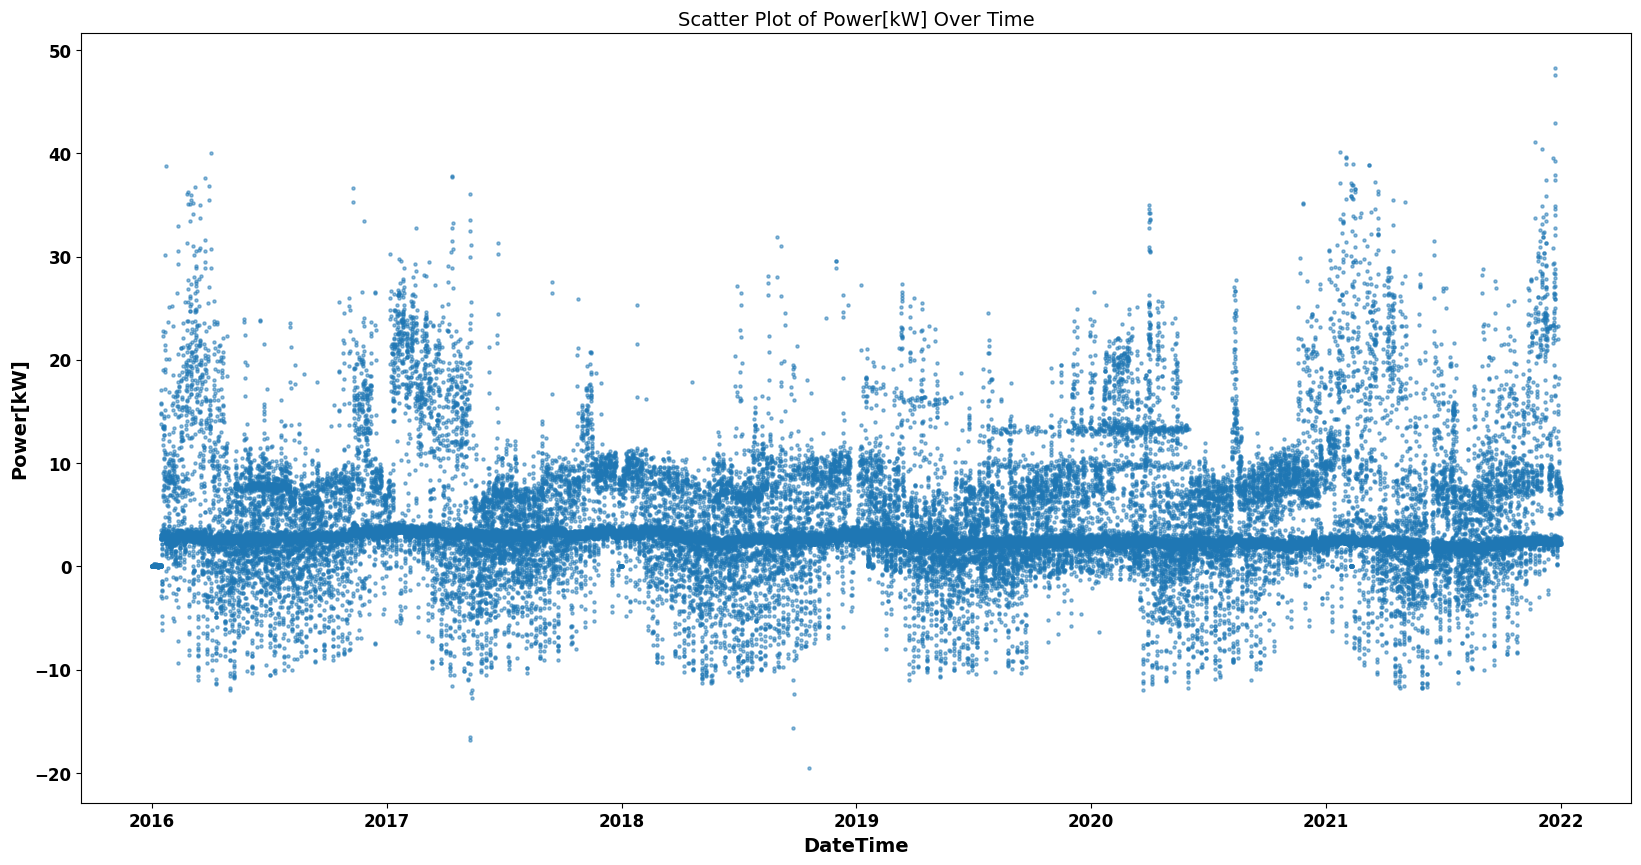

In [6]:
# Itentify outliers in the power column.

# Create a scatter plot of DateTime vs. Power[kW]
plt.scatter(power_column.index, power_column, s=5, alpha=0.5)
plt.xlabel('DateTime')
plt.ylabel('Power[kW]')
plt.title('Scatter Plot of Power[kW] Over Time')
plt.show()

# Calculate Z-scores
z_scores = (power_column - power_column.mean()) / power_column.std()

threshold = 3

# Identify outliers
outliers = power_column[np.abs(z_scores) > threshold]

<class 'pandas.core.series.Series'>
DatetimeIndex: 1221 entries, 2016-01-18 08:00:00 to 2021-12-27 09:00:00
Series name: Power[kW]
Non-Null Count  Dtype  
--------------  -----  
1221 non-null   float64
dtypes: float64(1)
memory usage: 19.1 KB


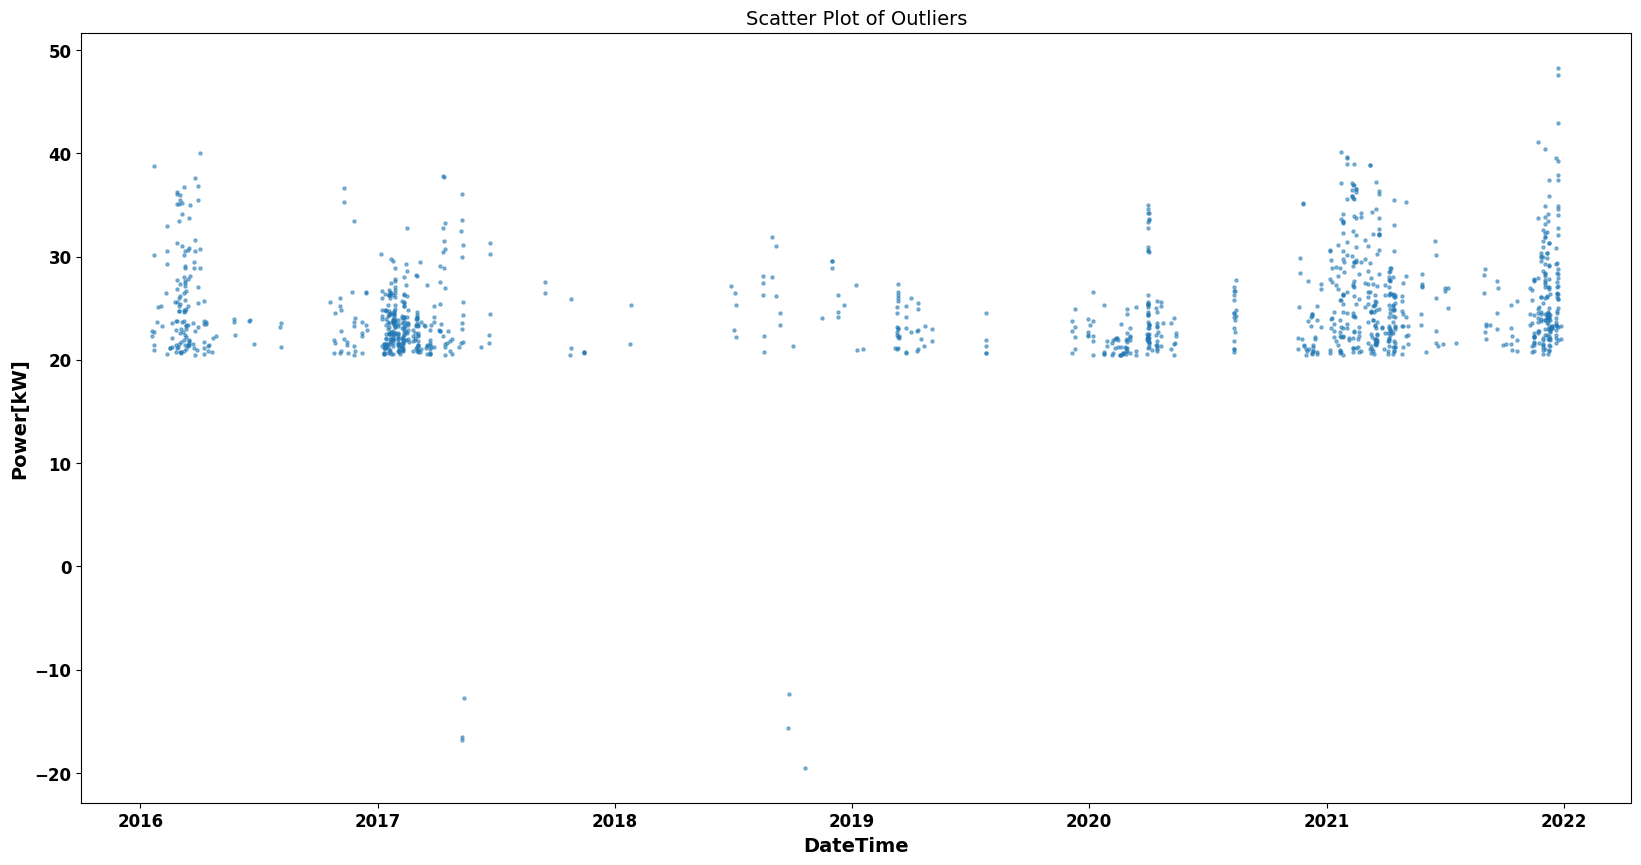

In [7]:
# Print outliers.

outliers.info()
plt.scatter(outliers.index, outliers, s=5, alpha=0.5)
plt.xlabel('DateTime')
plt.ylabel('Power[kW]')
plt.title('Scatter Plot of Outliers')
plt.show()

True


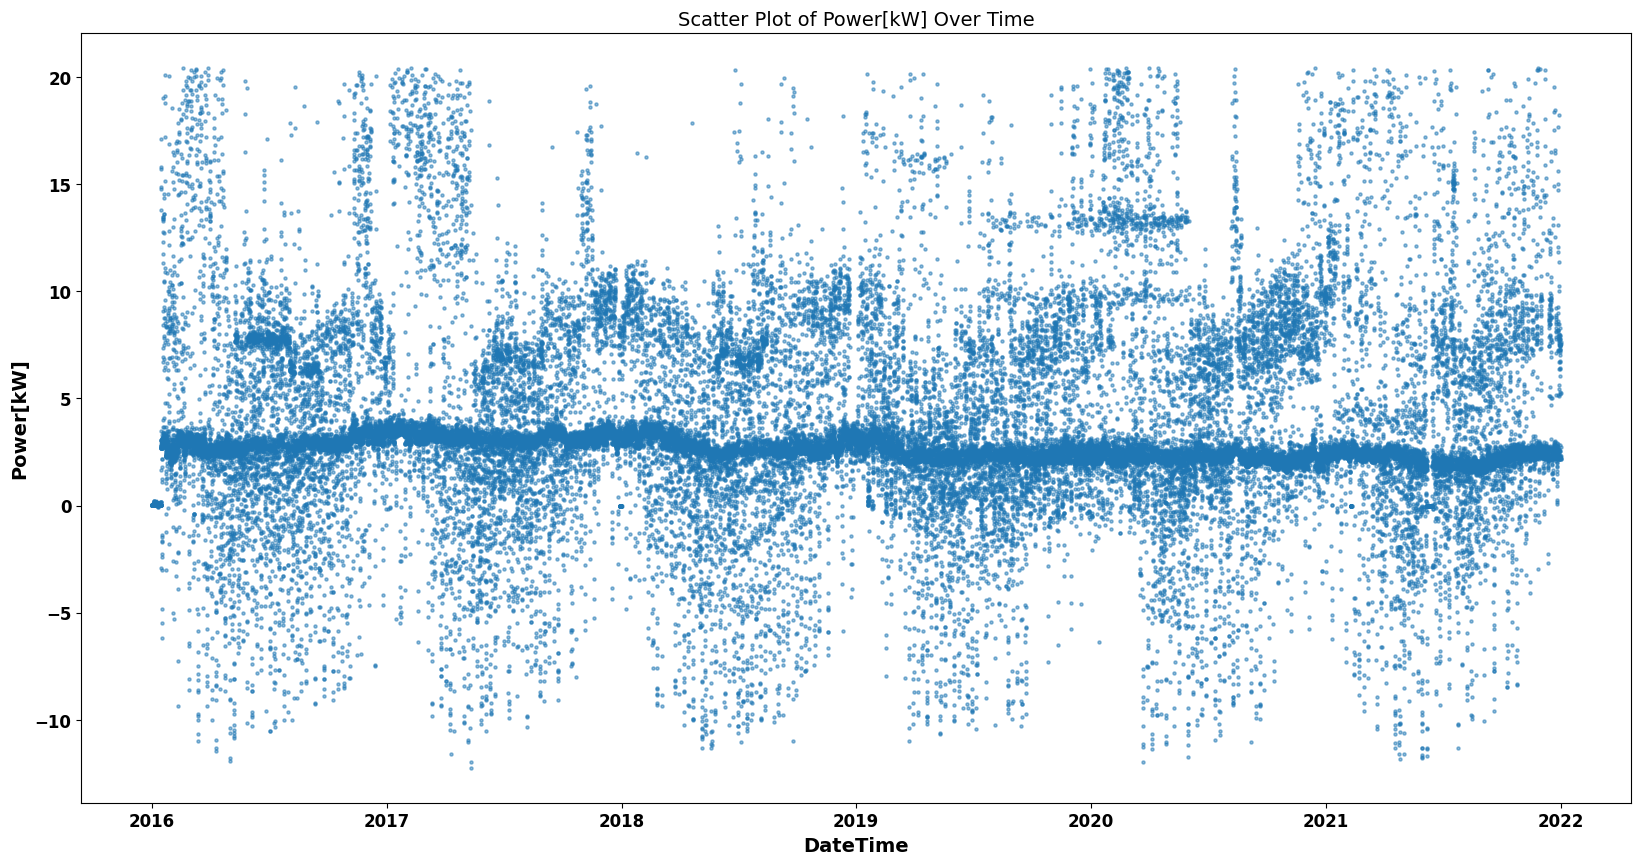

In [8]:
# Replace the outliers with NAN values.

# Replace the outliers with NAN.
power_column[np.abs(z_scores) > threshold] = np.nan
print(power_column.isna().any())

# Create a scatter plot of DateTime vs. Power[kW]
plt.scatter(power_column.index, power_column, s=5, alpha=0.5)
plt.xlabel('DateTime')
plt.ylabel('Power[kW]')
plt.title('Scatter Plot of Power[kW] Over Time')
plt.show()

NAN Values: False


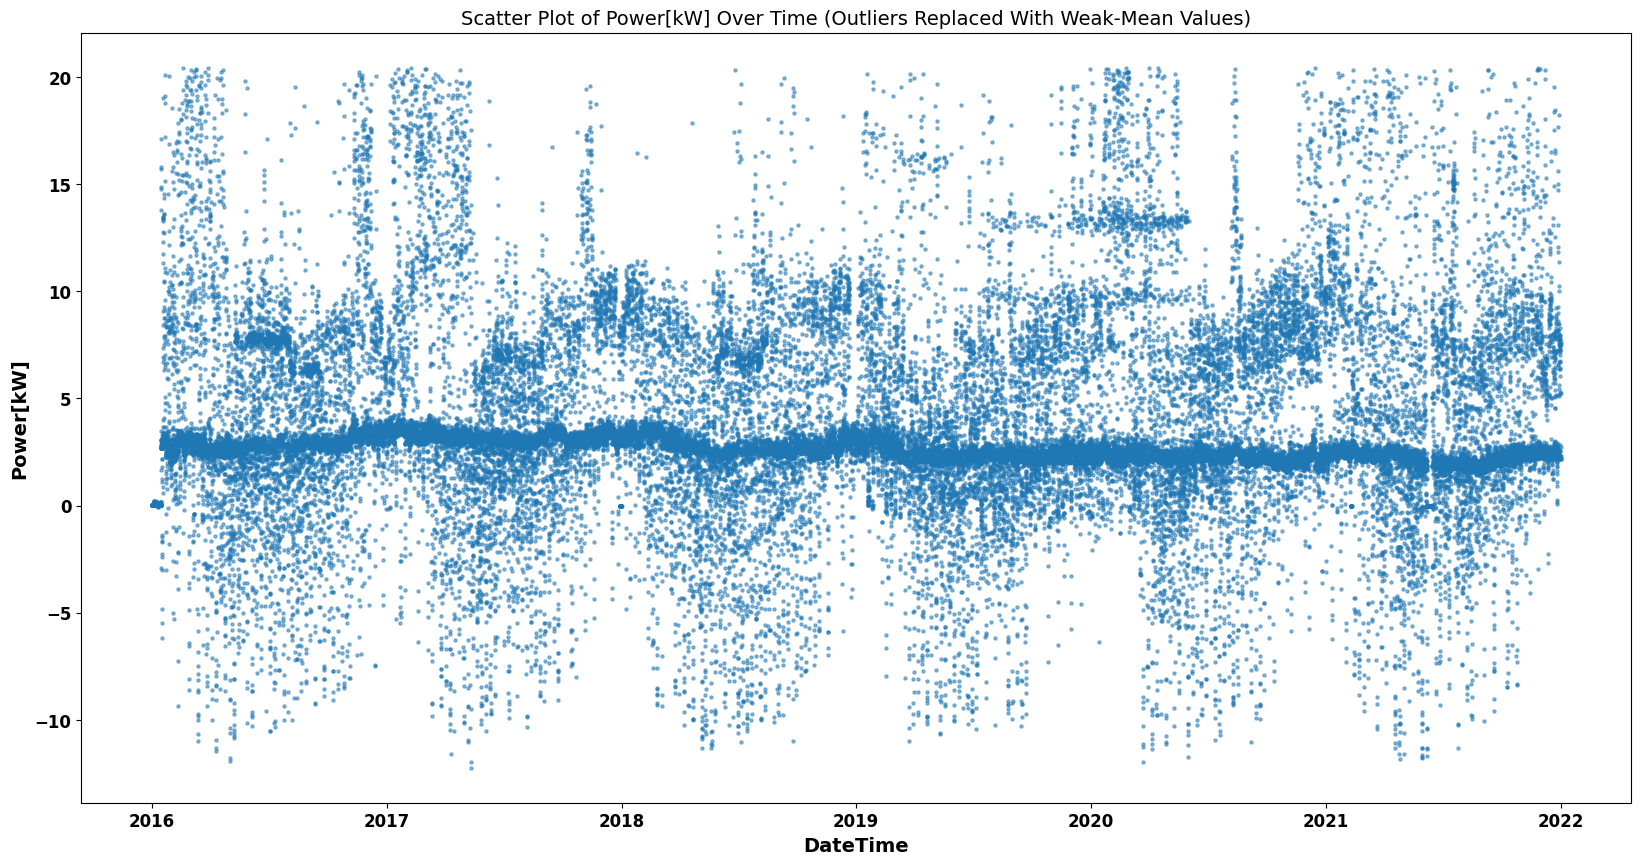

In [9]:
# Manage dataset's nullity.

def fillna_week_mean(data):
    # If there are missing values
    for i in range(len(data)):
        # If the value is NaN
        if pd.isna(data[i]):
            same_hour_week = data[i-24*7:i:24]
            # If there are any non-NaN values in the past week
            if same_hour_week.count() > 0:
                # Replace NaN with the mean of the same hour from the past week
                data[i] = same_hour_week.mean()
    return data

power_column = fillna_week_mean(power_column)

print(f'NAN Values: {power_column.isna().any()}')

# Create a scatter plot of DateTime vs. Power[kW]
plt.scatter(power_column.index, power_column, s=5, alpha=0.5)
plt.xlabel('DateTime')
plt.ylabel('Power[kW]')
plt.title('Scatter Plot of Power[kW] Over Time (Outliers Replaced With Weak-Mean Values)')
plt.show()

**Handle Multicollinearity**

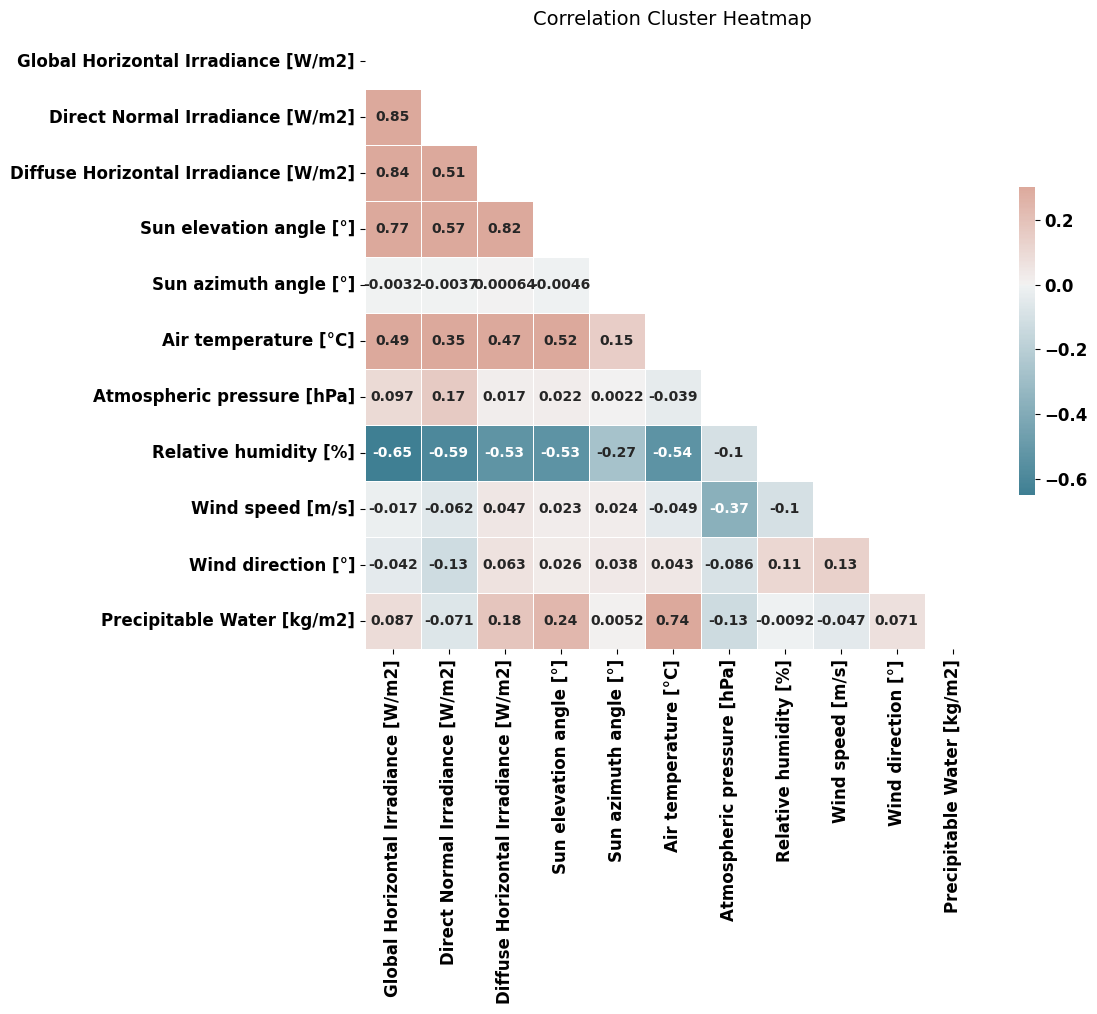

In [10]:
# Plot the correlations.

# Calculate the correlation matrix
correlation_matrix = weather.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Title for the heatmap
plt.title('Correlation Cluster Heatmap')

# Show the plot
plt.show()

In [11]:
# Drop highly correlated columns.

# Find pairs with correlation greater than 0.8
high_correlation_pairs = np.where(np.abs(correlation_matrix) > 0.80)

# Create a set to store pairs of features
feature_pairs_to_drop = set()

# Iterate through the pairs
for i, j in zip(high_correlation_pairs[0], high_correlation_pairs[1]):
    if i != j:
        feature1 = correlation_matrix.columns[i]
        feature2 = correlation_matrix.columns[j]
        
        # Check if the pair has not been added already (to avoid duplicates)
        if (feature2, feature1) not in feature_pairs_to_drop:
            feature_pairs_to_drop.add((feature1, feature2))
            
print(f'Feature pairs having high correlation values: {feature_pairs_to_drop}')

# Drop the redundant features.
weather_reduced = weather.drop(columns=['Global Horizontal Irradiance [W/m2]', 'Sun elevation angle [°]'])

Feature pairs having high correlation values: {('Global Horizontal Irradiance [W/m2]', 'Direct Normal Irradiance [W/m2]'), ('Global Horizontal Irradiance [W/m2]', 'Diffuse Horizontal Irradiance [W/m2]'), ('Diffuse Horizontal Irradiance [W/m2]', 'Sun elevation angle [°]')}


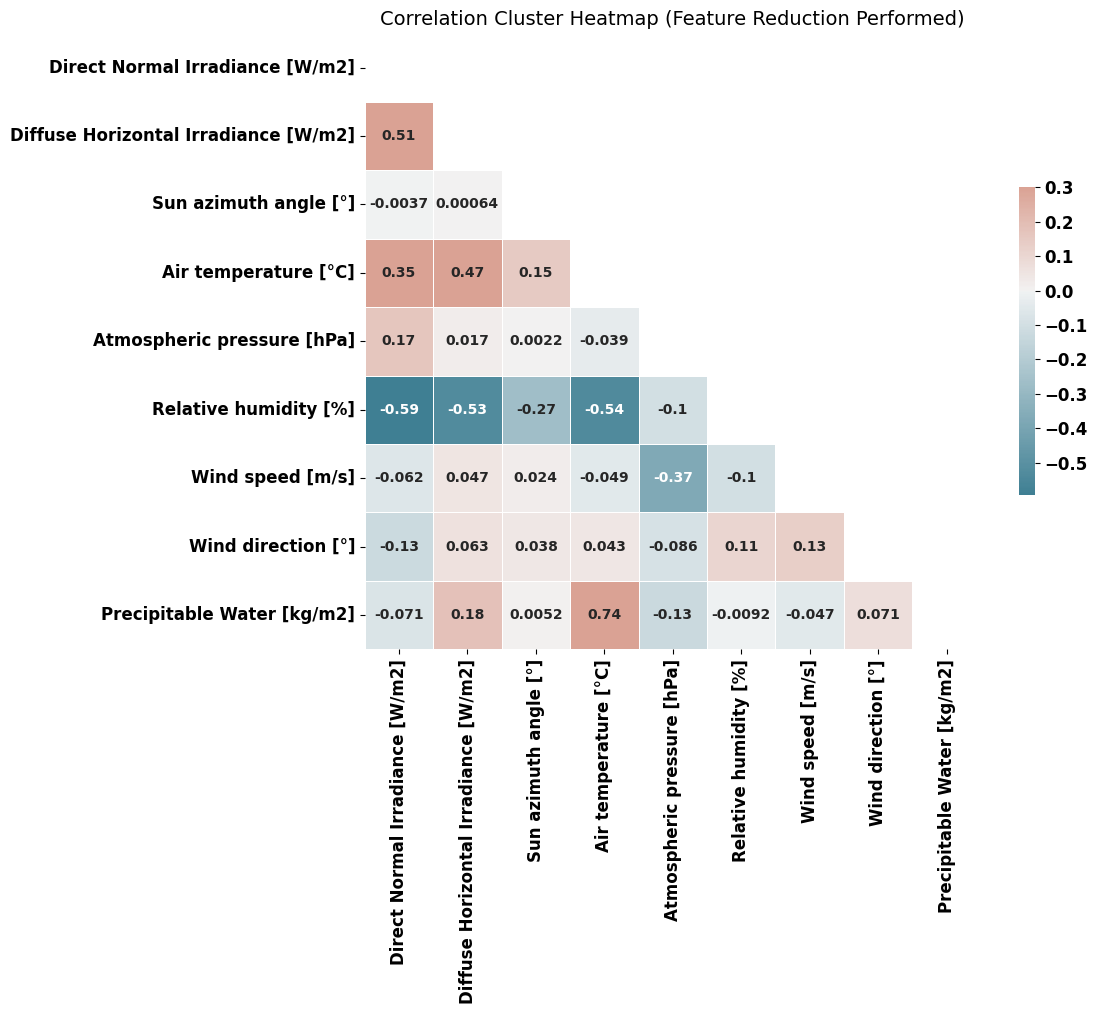

In [12]:
# Replot the correlations.

# Calculate the correlation matrix
correlation_matrix = weather_reduced.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Title for the heatmap
plt.title('Correlation Cluster Heatmap (Feature Reduction Performed)')

# Show the plot
plt.show()

In [13]:
# Merge the weather and power columns.

weather_power = pd.concat([weather, power_column], axis=1)
weather_power

,Global Horizontal Irradiance [W/m2],Direct Normal Irradiance [W/m2],Diffuse Horizontal Irradiance [W/m2],Sun elevation angle [°],Sun azimuth angle [°],Air temperature [°C],Atmospheric pressure [hPa],Relative humidity [%],Wind speed [m/s],Wind direction [°],Precipitable Water [kg/m2],Power[kW]
Datetime,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,-59.9775,-158.7825,7.425,1020.450,81.550,5.150,217.00,15.250,0.020000
2016-01-01 01:00:00,0.0,0.0,0.0,-54.8825,-134.7825,7.375,1020.900,84.200,4.525,221.50,14.100,0.020000
2016-01-01 02:00:00,0.0,0.0,0.0,-47.3225,-116.2300,6.625,1021.450,88.350,3.875,223.00,11.700,0.021000
2016-01-01 03:00:00,0.0,0.0,0.0,-38.5425,-101.5900,5.850,1021.950,91.950,3.350,224.50,9.850,0.022667
2016-01-01 04:00:00,0.0,0.0,0.0,-29.2975,-89.1825,5.200,1022.350,93.750,2.850,230.50,8.925,0.021000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.0,0.0,0.0,-34.2325,95.5150,12.800,1019.975,89.300,5.625,251.25,17.450,2.191000
2021-12-31 20:00:00,0.0,0.0,0.0,-43.3050,108.9200,12.650,1020.525,89.300,5.400,249.00,16.900,2.331833
2021-12-31 21:00:00,0.0,0.0,0.0,-51.5650,125.3925,12.725,1020.700,89.575,5.500,247.00,17.275,2.227833


# Pre-mining

**Seasonality**

In [14]:
# Add seasonality columns.
weather_power['Hour'] = weather_power.index.hour
weather_power['Day'] = weather_power.index.day
weather_power['DayOfWeek'] = weather_power.index.day_of_week
weather_power['DayOfYear'] = weather_power.index.day_of_year
weather_power['Month'] = weather_power.index.month
weather_power['Year'] = weather_power.index.year

# Preserve the target column to remain as the last column.
target_column = weather_power['Power[kW]']
weather_power.drop(columns='Power[kW]', inplace=True)
weather_power['Power[kW]'] = target_column


weather_power

,Global Horizontal Irradiance [W/m2],Direct Normal Irradiance [W/m2],Diffuse Horizontal Irradiance [W/m2],Sun elevation angle [°],Sun azimuth angle [°],Air temperature [°C],Atmospheric pressure [hPa],Relative humidity [%],Wind speed [m/s],Wind direction [°],Precipitable Water [kg/m2],Hour,Day,DayOfWeek,DayOfYear,Month,Year,Power[kW]
Datetime,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,-59.9775,-158.7825,7.425,1020.450,81.550,5.150,217.00,15.250,0,1,4,1,1,2016,0.020000
2016-01-01 01:00:00,0.0,0.0,0.0,-54.8825,-134.7825,7.375,1020.900,84.200,4.525,221.50,14.100,1,1,4,1,1,2016,0.020000
2016-01-01 02:00:00,0.0,0.0,0.0,-47.3225,-116.2300,6.625,1021.450,88.350,3.875,223.00,11.700,2,1,4,1,1,2016,0.021000
2016-01-01 03:00:00,0.0,0.0,0.0,-38.5425,-101.5900,5.850,1021.950,91.950,3.350,224.50,9.850,3,1,4,1,1,2016,0.022667
2016-01-01 04:00:00,0.0,0.0,0.0,-29.2975,-89.1825,5.200,1022.350,93.750,2.850,230.50,8.925,4,1,4,1,1,2016,0.021000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.0,0.0,0.0,-34.2325,95.5150,12.800,1019.975,89.300,5.625,251.25,17.450,19,31,4,365,12,2021,2.191000
2021-12-31 20:00:00,0.0,0.0,0.0,-43.3050,108.9200,12.650,1020.525,89.300,5.400,249.00,16.900,20,31,4,365,12,2021,2.331833
2021-12-31 21:00:00,0.0,0.0,0.0,-51.5650,125.3925,12.725,1020.700,89.575,5.500,247.00,17.275,21,31,4,365,12,2021,2.227833


Text(0.5, 1.0, 'Power Consumption')

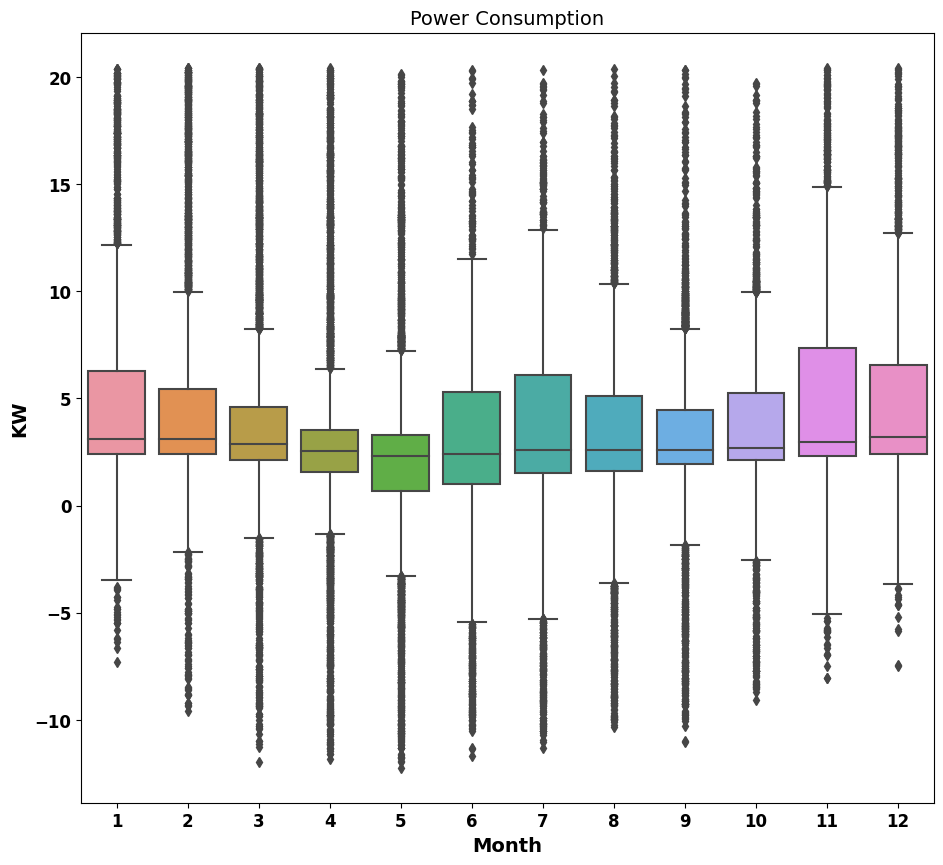

In [15]:
# Show box plots of the monthly power consumption.

fig, ax = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(data=weather_power, x=weather_power['Month'], y='Power[kW]', ax=ax)
ax.set_ylabel('KW')
ax.set_title('Power Consumption')

Text(0.5, 1.0, 'Power Consumption')

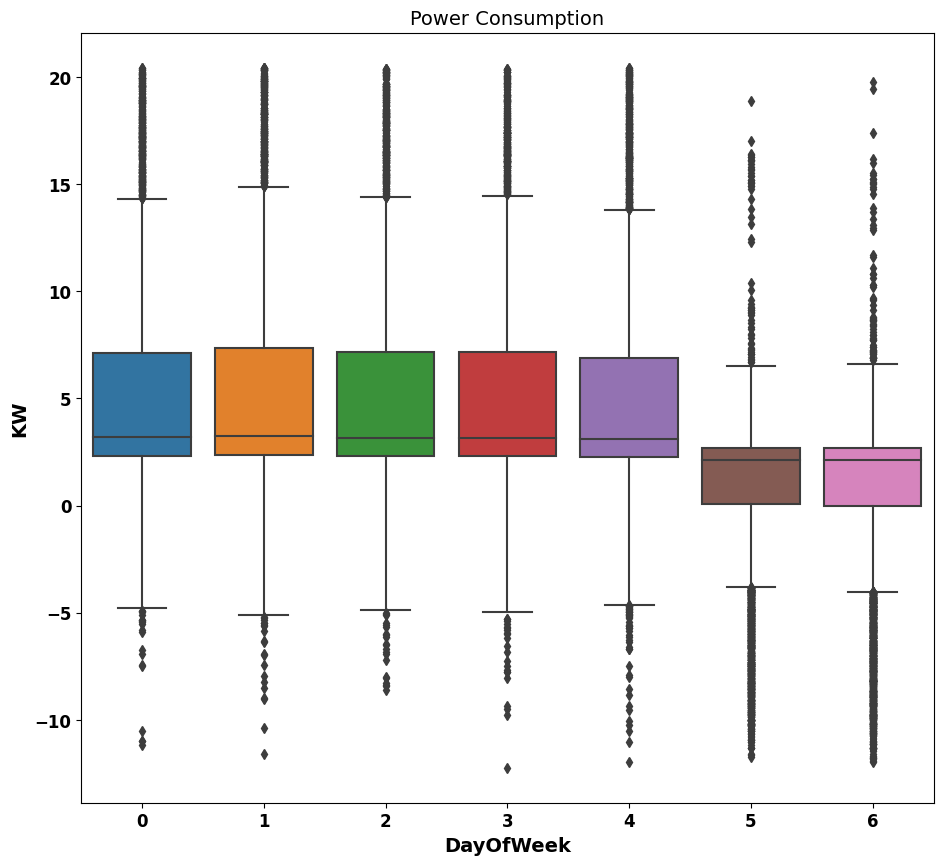

In [16]:
# Show box plots of the weekly power consumption.

fig, ax = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(data=weather_power, x=weather_power['DayOfWeek'], y='Power[kW]', ax=ax)
ax.set_ylabel('KW')
ax.set_title('Power Consumption')

Text(0.5, 1.0, 'Power Consumption')

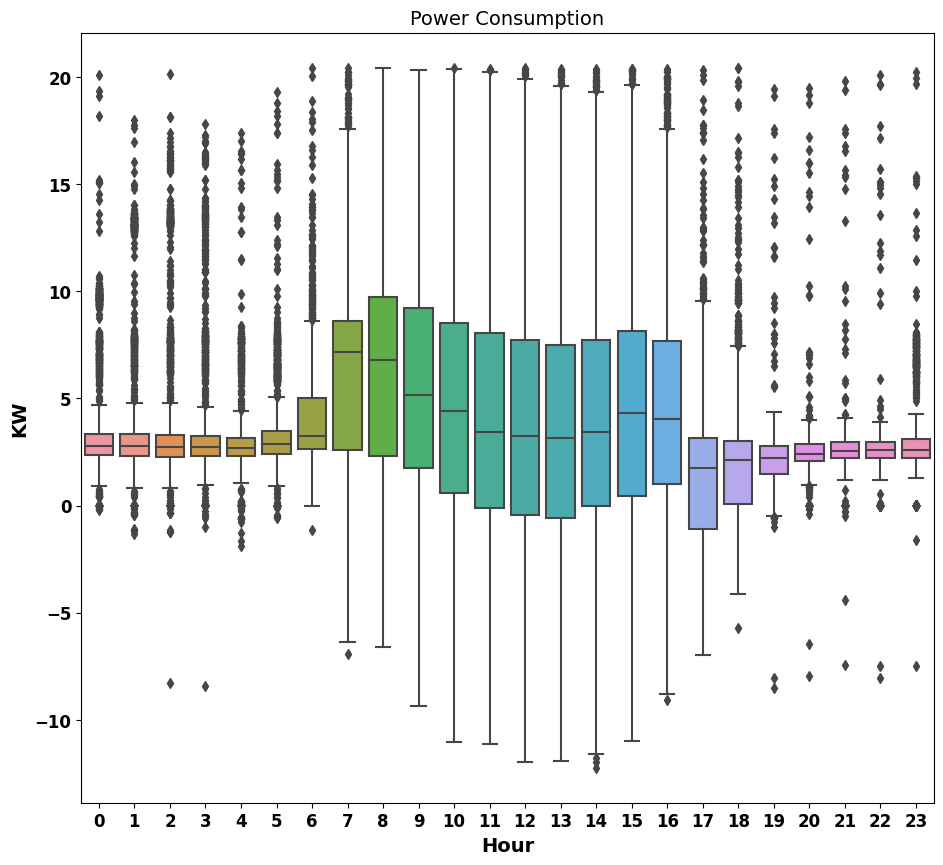

In [17]:
# Show box plots of the weekly power consumption.

fig, ax = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(data=weather_power, x=weather_power['Hour'], y='Power[kW]', ax=ax)
ax.set_ylabel('KW')
ax.set_title('Power Consumption')

**Forcasting**

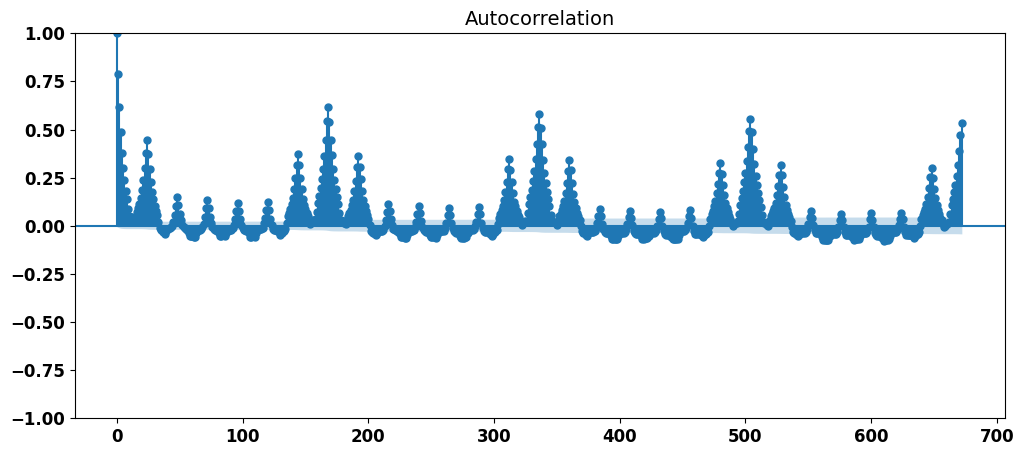

In [18]:
# Add autocorrelation.

# Plot the autocorrelation function
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(weather_power['Power[kW]'], lags=24*7*4, ax=ax) 
plt.show()

In [19]:
# Add lag features.

weather_power['lag_1'] = weather_power['Power[kW]'].shift(1)
weather_power['lag_168'] = weather_power['Power[kW]'].shift(168)

# Preserve the target column to remain as the last column.
target_column = weather_power['Power[kW]']
weather_power.drop(columns='Power[kW]', inplace=True)
weather_power['Power[kW]'] = target_column

weather_power

,Global Horizontal Irradiance [W/m2],Direct Normal Irradiance [W/m2],Diffuse Horizontal Irradiance [W/m2],Sun elevation angle [°],Sun azimuth angle [°],Air temperature [°C],Atmospheric pressure [hPa],Relative humidity [%],Wind speed [m/s],Wind direction [°],Precipitable Water [kg/m2],Hour,Day,DayOfWeek,DayOfYear,Month,Year,lag_1,lag_168,Power[kW]
Datetime,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,-59.9775,-158.7825,7.425,1020.450,81.550,5.150,217.00,15.250,0,1,4,1,1,2016,NaN,NaN,0.020000
2016-01-01 01:00:00,0.0,0.0,0.0,-54.8825,-134.7825,7.375,1020.900,84.200,4.525,221.50,14.100,1,1,4,1,1,2016,0.020000,NaN,0.020000
2016-01-01 02:00:00,0.0,0.0,0.0,-47.3225,-116.2300,6.625,1021.450,88.350,3.875,223.00,11.700,2,1,4,1,1,2016,0.020000,NaN,0.021000
2016-01-01 03:00:00,0.0,0.0,0.0,-38.5425,-101.5900,5.850,1021.950,91.950,3.350,224.50,9.850,3,1,4,1,1,2016,0.021000,NaN,0.022667
2016-01-01 04:00:00,0.0,0.0,0.0,-29.2975,-89.1825,5.200,1022.350,93.750,2.850,230.50,8.925,4,1,4,1,1,2016,0.022667,NaN,0.021000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.0,0.0,0.0,-34.2325,95.5150,12.800,1019.975,89.300,5.625,251.25,17.450,19,31,4,365,12,2021,5.271500,2.621833,2.191000
2021-12-31 20:00:00,0.0,0.0,0.0,-43.3050,108.9200,12.650,1020.525,89.300,5.400,249.00,16.900,20,31,4,365,12,2021,2.191000,2.264167,2.331833
2021-12-31 21:00:00,0.0,0.0,0.0,-51.5650,125.3925,12.725,1020.700,89.575,5.500,247.00,17.275,21,31,4,365,12,2021,2.331833,2.264333,2.227833


In [20]:
# Fill NaNs in lag features with actual values from the time series.

weather_power['lag_1'].bfill(inplace=True)
weather_power['lag_168'].bfill(inplace=True)

weather_power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2016-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Global Horizontal Irradiance [W/m2]   52608 non-null  float64
 1   Direct Normal Irradiance [W/m2]       52608 non-null  float64
 2   Diffuse Horizontal Irradiance [W/m2]  52608 non-null  float64
 3   Sun elevation angle [°]               52608 non-null  float64
 4   Sun azimuth angle [°]                 52608 non-null  float64
 5   Air temperature [°C]                  52608 non-null  float64
 6   Atmospheric pressure [hPa]            52608 non-null  float64
 7   Relative humidity [%]                 52608 non-null  float64
 8   Wind speed [m/s]                      52608 non-null  float64
 9   Wind direction [°]                    52608 non-null  float64
 10  Precipitable Water [kg/m2]            5

In [21]:
weather_power.shape

(52608, 20)

In [22]:
weather_power.describe()

,Global Horizontal Irradiance [W/m2],Direct Normal Irradiance [W/m2],Diffuse Horizontal Irradiance [W/m2],Sun elevation angle [°],Sun azimuth angle [°],Air temperature [°C],Atmospheric pressure [hPa],Relative humidity [%],Wind speed [m/s],Wind direction [°],Precipitable Water [kg/m2],Hour,Day,DayOfWeek,DayOfYear,Month,Year,lag_1,lag_168,Power[kW]
count,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000
mean,125.714967,115.795487,66.780756,0.400995,0.338663,11.330529,1014.913345,79.092206,3.871198,192.277719,17.572704,11.500000,15.732664,3.000456,183.166971,6.521898,2018.499544,3.638718,3.624063,3.638760
std,198.549965,213.284248,93.928631,30.119677,97.432016,6.807901,10.190109,15.254877,1.907318,90.802616,7.916851,6.922252,8.801454,1.999677,105.463784,3.449019,1.708197,4.409400,4.409463,4.409376
min,0.000000,0.000000,0.000000,-61.635000,-169.555000,-10.800000,969.450000,20.675000,0.050000,0.000000,1.725000,0.000000,1.000000,0.000000,1.000000,1.000000,2016.000000,-12.228500,-12.228500,-12.228500
25%,0.000000,0.000000,0.000000,-21.585000,-86.860625,6.200000,1009.125000,70.200000,2.425000,120.000000,11.325000,5.750000,8.000000,1.000000,92.000000,4.000000,2017.000000,2.041958,2.031625,2.042000
50%,5.500000,0.000000,5.250000,0.800000,0.270000,10.950000,1015.700000,83.350000,3.550000,211.000000,16.425000,11.500000,16.000000,3.000000,183.000000,7.000000,2018.500000,2.759750,2.754500,2.759750
75%,181.500000,124.062500,113.500000,22.501250,86.452500,16.250000,1021.750000,91.106250,4.975000,254.500000,22.850000,17.250000,23.000000,5.000000,274.250000,10.000000,2020.000000,5.166333,5.117375,5.166333
max,920.500000,971.750000,439.000000,61.590000,172.352500,39.475000,1047.750000,99.500000,14.800000,360.000000,48.225000,23.000000,31.000000,6.000000,366.000000,12.000000,2021.000000,20.432500,20.432500,20.432500


In [23]:
weather_power.dtypes

Global Horizontal Irradiance [W/m2]     float64
Direct Normal Irradiance [W/m2]         float64
Diffuse Horizontal Irradiance [W/m2]    float64
Sun elevation angle [°]                 float64
Sun azimuth angle [°]                   float64
Air temperature [°C]                    float64
Atmospheric pressure [hPa]              float64
Relative humidity [%]                   float64
Wind speed [m/s]                        float64
Wind direction [°]                      float64
Precipitable Water [kg/m2]              float64
Hour                                      int32
Day                                       int32
DayOfWeek                                 int32
DayOfYear                                 int32
Month                                     int32
Year                                      int32
lag_1                                   float64
lag_168                                 float64
Power[kW]                               float64
dtype: object

**Model Selection**

In [24]:
# Split data into train and test.

# Split the data into 80% training and 20% testing.
X_train, X_test, y_train, y_test = train_test_split(weather_power.iloc[:, :-1], weather_power.iloc[:, -1], test_size=0.2, random_state=42)

len(X_train)

42086

In [25]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [27]:
y_pred_lr = lr.predict(X_test_scaled)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE: {mae:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R2: {r2:.4f}")

Linear Regression MAE: 1.4276
Linear Regression RMSE: 2.4630
Linear Regression R2: 0.6850


* The baseline linear regression model demonstrates limited predictive capability, indicating the presence of nonlinear relationships in building energy consumption.

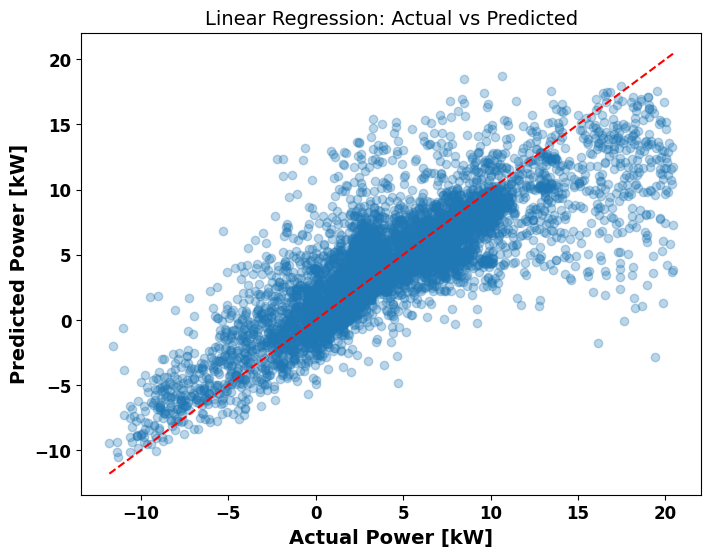

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--r')
plt.xlabel("Actual Power [kW]")
plt.ylabel("Predicted Power [kW]")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [31]:
y_pred_rf = rf.predict(X_test)

In [32]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R2: {r2_rf:.4f}")


Random Forest MAE: 1.0834
Random Forest RMSE: 2.0997
Random Forest R2: 0.7711


* The Random Forest regressor significantly outperforms the linear baseline, confirming the nonlinear nature of building energy consumption dynamics.

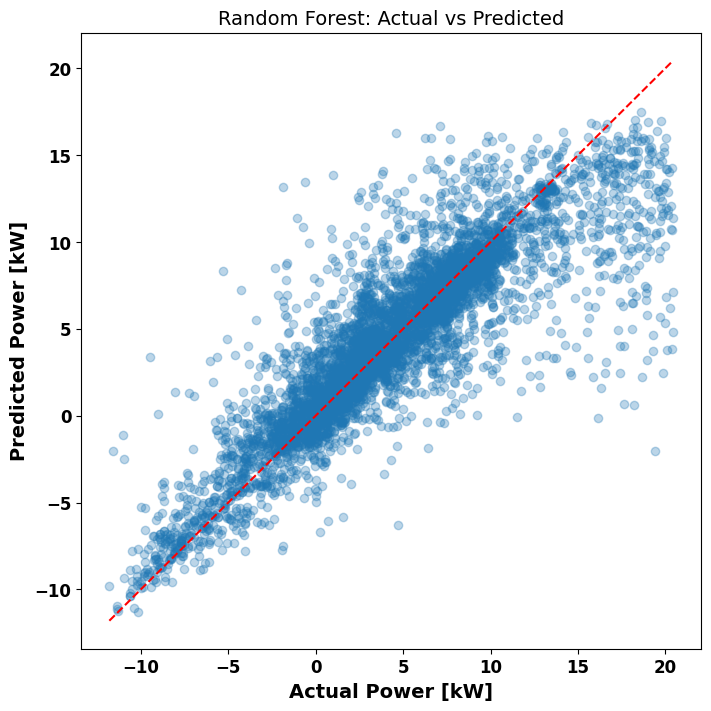

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--r')
plt.xlabel("Actual Power [kW]")
plt.ylabel("Predicted Power [kW]")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

* Points closer to the diagonal
* Less spread than LR

In [34]:
X = weather_power.iloc[:, :-1]

In [35]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances.head(10))

lag_1                                  0.682156
lag_168                                0.078733
Hour                                   0.053627
Sun azimuth angle [°]                  0.024632
DayOfYear                              0.017372
Atmospheric pressure [hPa]             0.013673
Precipitable Water [kg/m2]             0.012746
Wind direction [°]                     0.012420
Global Horizontal Irradiance [W/m2]    0.012191
Sun elevation angle [°]                0.012047
dtype: float64


* Optimization

In [36]:
threshold = np.percentile(y_train, 75)
print("High deman threshold: ", threshold)

High deman threshold:  5.221708333333334


* If predicted power > 75th percentile
* → reduce consumption by 10%

In [37]:
optimized_power = y_test.copy()

reduction_factor = 0.9

high_demand_mask = y_pred_rf > threshold
optimized_power[high_demand_mask] = (
    y_test[high_demand_mask] * reduction_factor
)

In [38]:
baseline_energy = y_test.sum()
optimized_energy = optimized_power.sum()

savings = baseline_energy - optimized_energy
savings_percent = 100 * savings / baseline_energy

print(f"Baseline energy: {baseline_energy:.4f} kWh")
print(f"Optimized energy: {optimized_energy:.4f} kWh")
print(f"Energy saved: {savings:.4f} kWh")
print(f"Savings(%): {savings_percent:.4f} %")

Baseline energy: 37892.7161 kWh
Optimized energy: 35566.9636 kWh
Energy saved: 2325.7526 kWh
Savings(%): 6.1377 %


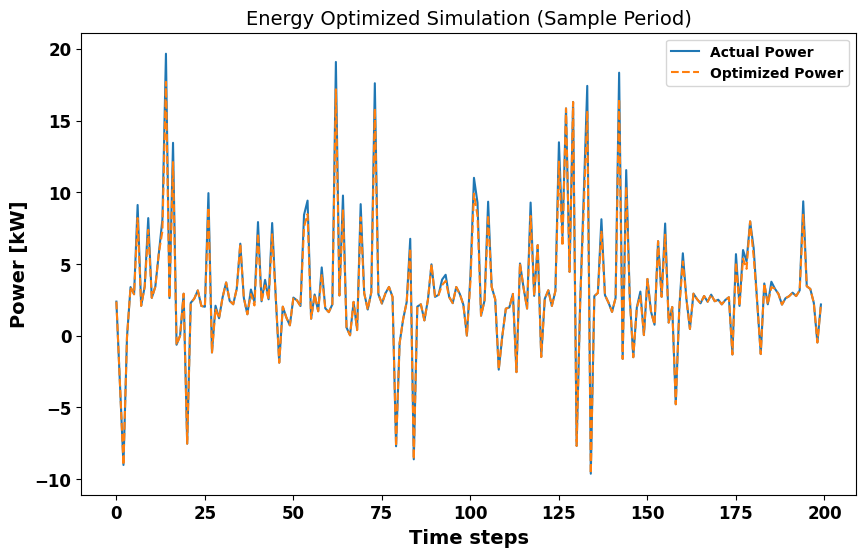

In [39]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:200], label="Actual Power")
plt.plot(optimized_power.values[:200], label="Optimized Power", linestyle="--")
plt.legend()
plt.title("Energy Optimized Simulation (Sample Period)")
plt.ylabel("Power [kW]")
plt.xlabel("Time steps")
plt.show()